# Step 1 : EDA

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

In [51]:
dataset=pd.read_csv('shipments.csv')
print(dataset.shape) #print shape of dataset with rows and columns

(10999, 12)


In [52]:
dataset.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


## Missing Values

In [53]:
features_with_na=[features for features in dataset.columns if dataset[features].isnull().sum()>1]
for feature in features_with_na:
    print(feature,np.round(dataset[feature].isnull.mean(),4), '% missing values')

There is no missing values

## Numerical Variables

In [54]:
# list of Numerical Variables
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes !='O' and feature not in ['ID']]
print('Number of Numerical Variables',len(numerical_features))

#visualize the numerical variables
dataset[numerical_features].head()

Number of Numerical Variables 7


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,4,2,177,3,44,1233,1
1,4,5,216,2,59,3088,1
2,2,2,183,4,48,3374,1
3,3,3,176,4,10,1177,1
4,2,2,184,3,46,2484,1


In [55]:
import numpy as np
num_features=['Prior_purchases','Weight_in_gms','Cost_of_the_Product']

for feature in num_features:
    dataset[feature]=np.log(dataset[feature])

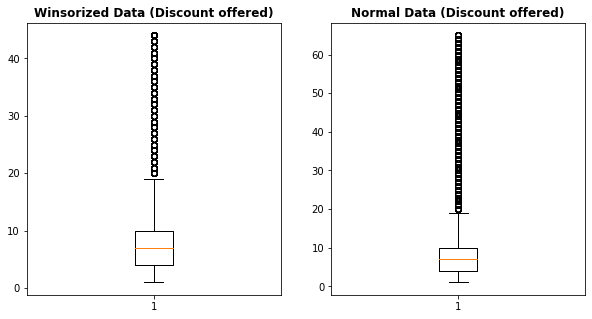

In [56]:
#Handling Outliers with winsorization
from scipy.stats.mstats import winsorize
data_win= winsorize(dataset["Discount_offered"],(0,0.10))

#Visualization
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(data_win)
plt.title("Winsorized Data (Discount offered)",fontsize=12,fontweight="bold")
plt.subplot(1,2,2)
plt.boxplot(dataset["Discount_offered"].values)
plt.title("Normal Data (Discount offered)",fontsize=12,fontweight="bold")
plt.show()

In [57]:
winsorized_data = dataset
winsorized_data["Discount_offered"] = data_win

## Categorical Variables

In [58]:
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtypes == 'O']
print('Number of Categorical Variables',len(categorical_features))

#visualize the categorical variables
dataset[categorical_features].head()

Number of Categorical Variables 4


,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


In [59]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(dataset[feature].unique())))

The feature is Warehouse_block and number of categories are 5
The feature is Mode_of_Shipment and number of categories are 3
The feature is Product_importance and number of categories are 3
The feature is Gender and number of categories are 2


In [60]:
def onehot_encode(dataset, column):
    dataset = dataset.copy()
    dummies = pd.get_dummies(dataset[column], prefix=column)
    dataset = pd.concat([dataset, dummies], axis=1)
    dataset = dataset.drop(column, axis=1)
    return dataset
# Binary encoding
dataset['Gender'] = dataset['Gender'].replace({'F': 0, 'M': 1})
    
# One-hot encoding
for column in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance']:
    dataset = onehot_encode(dataset, column=column)

# Feature Scaling

In [61]:
feature_scale = [feature for feature in dataset.columns if feature not in ['Reached.on.Time_Y.N']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(dataset[feature_scale])

MinMaxScaler()

In [62]:
dataset = pd.concat([dataset[["ID","Reached.on.Time_Y.N"]].reset_index(drop=True), pd.DataFrame(scaler.transform(dataset[feature_scale]),columns=feature_scale)],axis=1)

# Balancing Data

In [63]:
#### Independent and Dependent Features
X=dataset.drop(["Reached.on.Time_Y.N","ID"],axis=1)
y=dataset['Reached.on.Time_Y.N']

In [78]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8)

### Train Data

### Standard Random Forest

In [79]:
# random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [80]:
# generate dataset
X_train,y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [81]:
# define model
model1 = RandomForestClassifier(n_estimators=10)

In [82]:
# generate dataset
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [88]:
# evaluate model
scores1 = cross_val_score(model1, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [89]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores1))

Mean ROC AUC: 0.876


### Random Forest With Class Weighting

In [90]:
# class balanced random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [91]:
# generate dataset
X_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [92]:
# define model
model2 = RandomForestClassifier(n_estimators=10, class_weight='balanced')

In [93]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [94]:
# evaluate model
scores2 = cross_val_score(model2, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [95]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores2))

Mean ROC AUC: 0.872


### Random Forest With Bootstrap Class Weighting

In [96]:
# bootstrap class balanced random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [97]:
# generate dataset
X_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [98]:
# define model
model3 = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')

In [99]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [100]:
# evaluate model
scores3 = cross_val_score(model3, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [101]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores3))

Mean ROC AUC: 0.869


### Random Forest With Random Undersampling

In [102]:
# random forest with random undersampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier### Random Forest With Bootstrap Class Weighting

In [103]:
# generate dataset
X_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [104]:
# define model
model4 = BalancedRandomForestClassifier(n_estimators=10)

In [105]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [106]:
# evaluate model
scores4 = cross_val_score(model4, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [107]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores4))

Mean ROC AUC: 0.961


### Easy Ensemble

In [108]:
# easy ensemble for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import EasyEnsembleClassifier

In [109]:
# generate dataset
X_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [110]:
# define model
model5 = EasyEnsembleClassifier(n_estimators=10)

In [111]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [112]:
# evaluate model
scores5 = cross_val_score(model5, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [113]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores5))

Mean ROC AUC: 0.963


In [114]:
data = {"MODEL":pd.Series(['Standard Random Forest','Random Forest With Class Weighting','Random Forest With Bootstrap Class Weighting','Random Forest With Random Undersampling','Easy Ensemble']),
        "Mean ROC AUC":pd.Series([mean(scores1),mean(scores2),mean(scores3),mean(scores4),mean(scores5)])}
table=pd.DataFrame(data)
table 

,MODEL,Mean ROC AUC
0,Standard Random Forest,0.875747
1,Random Forest With Class Weighting,0.872325
2,Random Forest With Bootstrap Class Weighting,0.869113
3,Random Forest With Random Undersampling,0.960539
4,Easy Ensemble,0.963258


### Test Data

### Standard Random Forest

In [115]:
# random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [116]:
# generate dataset
X_test,y_test = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [117]:
# define model
model1 = RandomForestClassifier(n_estimators=10)

In [118]:
# generate dataset
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [120]:
# evaluate model
scores1 = cross_val_score(model1, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [121]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores1))

Mean ROC AUC: 0.874


### Random Forest With Class Weighting

In [122]:
# class balanced random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [123]:
# generate dataset
X_test,y_test = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [124]:
# define model
model2 = RandomForestClassifier(n_estimators=10, class_weight='balanced')

In [125]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [126]:
# evaluate model
scores2 = cross_val_score(model2, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [127]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores2))

Mean ROC AUC: 0.876


### Random Forest With Bootstrap Class Weighting

In [128]:
# bootstrap class balanced random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [129]:
# generate dataset
X_test,y_test = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [130]:
# define model
model3 = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')

In [131]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [132]:
# evaluate model
scores3 = cross_val_score(model3, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [133]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores3))

Mean ROC AUC: 0.881


### Random Forest With Random Undersampling

In [134]:
# random forest with random undersampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier### Random Forest With Bootstrap Class Weighting

In [135]:
# generate dataset
X_test,y_test = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [136]:
# define model
model4 = BalancedRandomForestClassifier(n_estimators=10)

In [137]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [138]:
# evaluate model
scores4 = cross_val_score(model4, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [139]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores4))

Mean ROC AUC: 0.966


### Easy Ensemble

In [140]:
# easy ensemble for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import EasyEnsembleClassifier

In [142]:
# generate dataset
X_test,y_test = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [143]:
# define model
model5 = EasyEnsembleClassifier(n_estimators=10)

In [144]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [146]:
# evaluate model
scores5 = cross_val_score(model5, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [147]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores5))

Mean ROC AUC: 0.962


In [148]:
data = {"MODEL":pd.Series(['Standard Random Forest','Random Forest With Class Weighting','Random Forest With Bootstrap Class Weighting','Random Forest With Random Undersampling','Easy Ensemble']),
        "Mean ROC AUC":pd.Series([mean(scores1),mean(scores2),mean(scores3),mean(scores4),mean(scores5)])}
table=pd.DataFrame(data)
table 

,MODEL,Mean ROC AUC
0,Standard Random Forest,0.873702
1,Random Forest With Class Weighting,0.875697
2,Random Forest With Bootstrap Class Weighting,0.880827
3,Random Forest With Random Undersampling,0.966401
4,Easy Ensemble,0.962130
